##Overview

At the core of CNNs are filters (aka weights, kernels, etc.) which convolve (slide) across our input to extract relevant features. The filters are initialized randomly but learn to act as feature extractors via parameter sharing.
<img src='https://madewithml.com/static/images/foundations/cnn/convolution.gif'>


#####**Objective:**
- Extract meaningful spatial substructure from encoded data.

#####**Advantages:**
- Small number of weights (shared)
- Parallelizable
- Detects spatial substrcutures (feature extractors)
- Interpretability via filters
- Can be used for processing in images, text, time-series, etc.

#####**Disadvantages:**
- Many hyperparameters (kernel size, strides, etc.) to tune.

#####**Miscellaneous:**
- Lot's of deep CNN architectures constantly updated for SOTA performance.
- Very popular feature extractor that acts as a foundation for many architectures.

##Set up
Let's set our seed and device.

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [2]:
SEED = 1234

In [3]:

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [4]:

# Set seeds for reproducibility
set_seeds(seed=SEED)

In [5]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


##Load data
We will download the AG News dataset, which consists of 120K text samples from 4 unique classes (Business, Sci/Tech, Sports, World)

In [6]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()


,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


## Preprocessing
We're going to clean up our input data first by doing operations such as lower text, removing stop (filler) words, filters using regular expressions, etc.

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [8]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we']


In [9]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)  # separate punctuation tied to words
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

In [10]:

# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [11]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says

sharon accepts plan reduce gaza army operation haaretz says


##Split data

In [12]:
import collections
from sklearn.model_selection import train_test_split

In [13]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15


In [14]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values


In [16]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: china battles north korea nuclear talks → World


##Label encoding
Next we'll define a LabelEncoder to encode our text labels into unique indices

In [17]:
import itertools


In [18]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [19]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index


{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [20]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")


y_train[0]: World
y_train[0]: 3


In [21]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


## Tokenizer
Our input data is text and we can't feed it directly to our models. So, we'll define a Tokenizer to convert our text input data into token indices. This means that every token (we can decide what a token is char, word, sub-word, etc.) is mapped to a unique index which allows us to represent our text as an array of indices.

In [22]:
import json
from collections import Counter
from more_itertools import take

In [23]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


We're going to restrict the number of tokens in our Tokenizer to the top 500 most frequent tokens (stop words already removed) because the full vocabulary size (~30K) is too large to run on Google Colab notebooks.

In [24]:
# Tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=500)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=500)>


In [25]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens


[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 166


In [26]:
# Convert texts to sequences of indices
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")


Text to indices:
  (preprocessed) → china <UNK> north korea nuclear talks
  (tokenized) → [ 16   1 285 142 114  24]




**Did we need to split the data first?**

> How come we applied the preprocessing functions to the entire dataset but tokenization after splitting the dataset? Does it matter?


**Answer**
>If you have preprocessing steps like standardization, etc. that are calculated, you need to separate the training and test set first before applying those operations. This is because we cannot apply any knowledge gained from the test set accidentally (data leak) during preprocessing/training. So for the tokenization process, it's important that we only fit using our train data split because during inference, our model will not always know every token so it's important to replicate that scenario with our validation and test splits as well. However for global preprocessing steps, like the preprocessing function where we aren't learning anything from the data itself, we can perform before splitting the data.






## One-hot encoding
One-hot encoding creates a binary column for each unique value for the feature we're trying to map. All of the values in each token's array will be 0 except at the index that this specific token is represented by.

There are 5 words in the vocabulary:

```
{
    "a": 0,
    "e": 1,
    "i": 2,
    "o": 3,
    "u": 4
}
```

Then the text aou would be represented by:

```
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
```

One-hot encoding allows us to represent our data in a way that our models can process the data and isn't biased by the actual value of the token (ex. if your labels were actual numbers).

>We have already applied one-hot encoding in the previous lessons when we encoded our labels. Each label was represented by a unique index but when determining loss, we effectively use it's one hot representation and compared it to the predicted probability distribution. We never explicitly wrote this out since all of our previous tasks were multi-class which means every input had just one output class, so the 0s didn't affect the loss (though it did matter during back propagation).

In [27]:
def to_categorical(seq, num_classes):
    """One-hot encode a sequence of tokens."""
    one_hot = np.zeros((len(seq), num_classes))
    for i, item in enumerate(seq):
        one_hot[i, item] = 1.
    return one_hot

In [28]:
# One-hot encoding
print (X_train[0])
print (len(X_train[0]))
cat = to_categorical(seq=X_train[0], num_classes=len(tokenizer))
print (cat)
print (cat.shape)

[ 16   1 285 142 114  24]
6
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(6, 500)


In [29]:
# Convert tokens to one-hot
vocab_size = len(tokenizer)
X_train = [to_categorical(seq, num_classes=vocab_size) for seq in X_train]
X_val = [to_categorical(seq, num_classes=vocab_size) for seq in X_val]
X_test = [to_categorical(seq, num_classes=vocab_size) for seq in X_test]


## Padding
Our inputs are all of varying length but we need each batch to be uniformly shaped. Therefore, we will use padding to make all the inputs in the batch the same length. Our padding index will be 0 (note that this is consistent with the "< PAD >" token defined in our Tokenizer).

>One-hot encoding creates a batch of shape (N, max_seq_len, vocab_size) so we'll need to be able to pad 3D sequences.

In [30]:

def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    num_classes = sequences[0].shape[-1]
    padded_sequences = np.zeros((len(sequences), max_seq_len, num_classes))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [31]:

# 3D sequences
print (X_train[0].shape, X_train[1].shape, X_train[2].shape)
print(X_train[1])
padded = pad_sequences(X_train[0:3])
print (padded.shape)
print(padded[1])


(6, 500) (5, 500) (6, 500)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(3, 6, 500)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##Dataset
We're going to create Datasets and DataLoaders to be able to efficiently create batches with our data splits.

In [32]:
FILTER_SIZE = 1 # unigram


In [33]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch)
        X = batch[:, 0]
        y = batch[:, 1]

        # Pad sequences
        X = pad_sequences(X, max_seq_len=self.max_filter_size)

        # Cast
        X = torch.FloatTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)


In [34]:
# Create datasets for embedding
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=FILTER_SIZE)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=FILTER_SIZE)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=FILTER_SIZE)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {test_dataset[0][0]}\n"
    f"  y: {test_dataset[0][1]}")


Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
  y: 1


In [35]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(test_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")


Sample batch:
  X: [64, 14, 500]
  y: [64]
Sample point:
  X: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cpu')
  y: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## CNN
We're going to learn about CNNs by applying them on 1D text data.

###Inputs
In the dummy example below, our inputs are composed of character tokens that are one-hot encoded. We have a batch of N samples, where each sample has 8 characters and each character is represented by an array of 10 values (vocab size=10). This gives our inputs the size (N, 8, 10).

>With PyTorch, when dealing with convolution, our inputs (X) need to have the channels as the second dimension, so our inputs will be (N, 10, 8).

In [36]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


In [37]:
# Assume all our inputs are padded to have the same # of words
batch_size = 64
max_seq_len = 8 # words per input
vocab_size = 10 # one hot size
x = torch.randn(batch_size, max_seq_len, vocab_size)
print(f"X: {x.shape}")
x = x.transpose(1, 2)
print(f"X: {x.shape}")


X: torch.Size([64, 8, 10])
X: torch.Size([64, 10, 8])


<img src='https://madewithml.com/static/images/foundations/cnn/inputs.png'>

##Filters
At the core of CNNs are filters (aka weights, kernels, etc.) which convolve (slide) across our input to extract relevant features. The filters are initialized randomly but learn to act as feature extractors via parameter sharing.

We can see convolution in the diagram below where we simplified the filters and inputs to be 2D for ease of visualization. Also note that the values are 0/1s but in reality they can be any floating point value.

<img src = 'https://madewithml.com/static/images/foundations/cnn/convolution.gif'>

Now let's return to our actual inputs x, which is of shape (8, 10) [max_seq_len, vocab_size] and we want to convolve on this input using filters. We will use 50 filters that are of size (1, 3) and has the same depth as the number of channels (num_channels = vocab_size = one_hot_size = 10). This gives our filter a shape of (3, 10, 50) [kernel_size, vocab_size, num_filters]
<img src='https://madewithml.com/static/images/foundations/cnn/filters.png'>

- **stride**: amount the filters move from one convolution operation to the next.

- **padding**: values (typically zero) padded to the input, typically to create a volume with whole number dimensions.

So far we've used a stride of 1 and VALID padding (no padding) but let's look at an example with a higher stride and difference between different padding approaches.

Padding types:

- VALID: no padding, the filters only use the "valid" values in the input. If the filter cannot reach all the input values (filters go left to right), the extra values on the right are dropped.
- SAME: adds padding evenly to the right (preferred) and left sides of the input so that all values in the input are processed.

<img src='https://madewithml.com/static/images/foundations/cnn/padding.png'>


We're going to use the Conv1d layer to process our inputs.

In [38]:
# Convolutional filters (VALID padding)
vocab_size = 10 # one hot size
num_filters = 50 # num filters
filter_size = 3 # filters are 3X3
stride = 1
padding = 0 # valid padding (no padding)
conv1 = nn.Conv1d(in_channels=vocab_size, out_channels=num_filters,
                  kernel_size=filter_size, stride=stride,
                  padding=padding, padding_mode="zeros")
print("conv: {}".format(conv1.weight.shape))


conv: torch.Size([50, 10, 3])


In [39]:
# Forward pass
z = conv1(x)
print(f"x: {x.shape}")
print (f"z: {z.shape}")

x: torch.Size([64, 10, 8])
z: torch.Size([64, 50, 6])


<img src='https://madewithml.com/static/images/foundations/cnn/conv.png'>

When we apply these filter on our inputs, we receive an output of shape (N, 6, 50). We get 50 for the output channel dim because we used 50 filters and 6 for the conv outputs because:

$$W_1 = \frac{W_2 - F + 2P}{S} + 1 = \frac{8 - 3 + 2(0)}{1} + 1 = 6$$

$$H_1 = \frac{H_2 - F + 2P}{S} + 1 = \frac{1 - 1 + 2(0)}{1} + 1 = 1$$

$$D_2 = D_1$$




Variable | Description
---|:---:|
W|width of each input = 8
H|height of each input = 1
D|depth (# of channels)
F|filter size = 3
P|padding = 0
S|stride = 1

Now we'll add padding so that the convolutional outputs are the same shape as our inputs. The amount of padding for the SAME padding can be determined using the same equation. We want out output to have the same width as our input, so we solve for P:

$$\frac{W-F+2P}{S} + 1 = W$$

$$P = \frac{S(W-1) - W + F}{2}$$

If $P$ is not a whole number, we round up (using math.ceil) and place the extra padding on the right side.

In [40]:
# Convolutional filters (SAME padding)
vocab_size = 10 # one hot size
num_filters = 50 # num filters
filter_size = 3 # filters are 3X3
stride = 1
conv = nn.Conv1d(in_channels=vocab_size, out_channels=num_filters,
                 kernel_size=filter_size, stride=stride)
print("conv: {}".format(conv.weight.shape))


conv: torch.Size([50, 10, 3])


In [41]:
# `SAME` padding
padding_left = int((conv.stride[0]*(max_seq_len-1) - max_seq_len + filter_size)/2)
padding_right = int(math.ceil((conv.stride[0]*(max_seq_len-1) - max_seq_len + filter_size)/2))
print (f"padding: {(padding_left, padding_right)}")


padding: (1, 1)


In [42]:
# Forward pass
z = conv(F.pad(x, (padding_left, padding_right)))
print (f"z: {z.shape}")



z: torch.Size([64, 50, 8])


>We will explore larger dimensional convolution layers in subsequent lessons. For example, Conv2D is used with 3D inputs (images, char-level text, etc.) and Conv3D is used for 4D inputs (videos, time-series, etc.).

##Pooling
The result of convolving filters on an input is a feature map. Due to the nature of convolution and overlaps, our feature map will have lots of redundant information. Pooling is a way to summarize a high-dimensional feature map into a lower dimensional one for simplified downstream computation. The pooling operation can be the max value, average, etc. in a certain receptive field. Below is an example of pooling where the outputs from a conv layer are 4X4 and we're going to apply max pool filters of size 2X2.

<img src='https://madewithml.com/static/images/foundations/cnn/pooling.png'>

$$W_2 = \frac{W_1 - F}{S} + 1 = \frac{4 - 2}{2} + 1 = 2$$

$$H_2 = \frac{H_1 - F}{S} + 1 = \frac{4 - 2}{2} + 1 = 2$$

$$D_2 = D_1$$



Variable | Description
---|:---:|
W|width of each input = 4
H|height of each input = 4
D|depth (# of channels)
F|filter size = 2
S|stride = 2


In our use case, we want to just take the one max value so we will use the MaxPool1D layer, so our max-pool filter size will be max_seq_len.

In [43]:

# Max pooling
pool_output = F.max_pool1d(z, z.size(2))
print("Size: {}".format(pool_output.shape))

Size: torch.Size([64, 50, 1])


## Batch normalization
The last topic we'll cover before constructing our model is batch normalization. It's an operation that will standardize (mean=0, std=1) the activations from the previous layer. Recall that we used to standardize our inputs in previous notebooks so our model can optimize quickly with larger learning rates. It's the same concept here but we continue to maintain standardized values throughout the repeated forward passes to further aid optimization.

In [44]:
# Batch normalization
batch_norm = nn.BatchNorm1d(num_features=num_filters)
z = batch_norm(conv(x)) # applied to activations (after conv layer & before pooling)
print (f"z: {z.shape}")


z: torch.Size([64, 50, 6])


In [45]:
# Mean and std before batchnorm
print (f"mean: {torch.mean(conv(x)):.2f}, std: {torch.std(conv(x)):.2f}")


mean: -0.00, std: 0.57


In [46]:
# Mean and std after batchnorm
print (f"mean: {torch.mean(z):.2f}, std: {torch.std(z):.2f}")


mean: 0.00, std: 1.00


##Modeling
###Model
Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (batch_size, max_seq_len).
2. Then we'll one-hot encode our tokenized inputs (batch_size, max_seq_len, vocab_size).
3. We'll apply convolution via filters (filter_size, vocab_size, num_filters) followed by batch normalization. Our filters act as character level n-gram detectors.
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities.

<img src='https://madewithml.com/static/images/foundations/cnn/model.png'>

>***Note from shashank***:
The dimensions in the above image (although correct but) are represented in a fucked up way!! Dont screw up your concepts. Read the dimension axes carefully (they are written correctly but visual display is a little counter intuitive)

In [47]:
NUM_FILTERS = 50
HIDDEN_DIM = 100
DROPOUT_P = 0.1
FILTER_SIZE=1

In [48]:

class CNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                 hidden_dim, dropout_p, num_classes):
        super(CNN, self).__init__()

        # Convolutional filters
        self.filter_size = filter_size
        self.conv = nn.Conv1d(
            in_channels=vocab_size, out_channels=num_filters,
            kernel_size=filter_size, stride=1, padding=0, padding_mode="zeros")
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)

        # FC layers
        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False,):

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Padding for `SAME` padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))

        # Conv outputs
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))
        z = F.max_pool1d(z, z.size(2)).squeeze(2)

        # FC layer
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [49]:
# Initialize model
model = CNN(vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
            hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)


<bound method Module.named_parameters of CNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


We used SAME padding (w/ stride=1) which means that the conv outputs will have the same width (max_seq_len) as our inputs. The amount of padding differs for each batch based on the max_seq_len but you can calculate it by solving for P in the equation below.

$$\frac{W_1 - F + 2P}{S} + 1 = W_2$$

$$\frac{\text{max_seq_len } - \text{ filter_size } + 2P}{\text{stride}} + 1 = \text{max_seq_len}$$

$$P = \frac{\text{stride}(\text{max_seq_len}-1) - \text{max_seq_len} + \text{filter_size}}{2}$$

If $P$ is not a whole number, we round up (using math.ceil) and place the extra padding on the right side.

##Training
Let's create the Trainer class that we'll use to facilitate training for our experiments. Notice that we're now moving the train function inside this class.

In [50]:
from torch.optim import Adam


In [83]:
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 100


In [84]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model


In [85]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [86]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)


In [87]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)


In [88]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 | train_loss: 0.75832, val_loss: 0.77993, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.75652, val_loss: 0.77989, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.75499, val_loss: 0.78033, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.75367, val_loss: 0.78044, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.75240, val_loss: 0.78059, lr: 1.00E-04, _patience: 2
Epoch: 6 | train_loss: 0.74164, val_loss: 0.77848, lr: 1.00E-04, _patience: 5
Epoch: 7 | train_loss: 0.74054, val_loss: 0.77808, lr: 1.00E-04, _patience: 5
Epoch: 8 | train_loss: 0.73956, val_loss: 0.77797, lr: 1.00E-04, _patience: 5
Epoch: 9 | train_loss: 0.73952, val_loss: 0.77789, lr: 1.00E-04, _patience: 5
Epoch: 10 | train_loss: 0.73901, val_loss: 0.77777, lr: 1.00E-04, _patience: 5
Epoch: 11 | train_loss: 0.73836, val_loss: 0.77778, lr: 1.00E-04, _patience: 4
Epoch: 12 | train_loss: 0.73813, val_loss: 0.77784, lr: 1.00E-04, _patience: 3
Epoch: 13 | train_loss: 0.73828, val_loss: 0.77787, lr: 1.00E

##Evaluation

In [89]:
import json
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support


In [90]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [91]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [92]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))


{
  "precision": 0.7140687694257777,
  "recall": 0.6957222222222222,
  "f1": 0.6953083387650868,
  "num_samples": 18000.0
}


In [93]:
# Save artifacts
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, 'tokenizer.json'))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)


##Inference

In [94]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results


In [95]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, 'tokenizer.json'))
model = CNN(
    vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)


CNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [96]:
# Initialize trainer
trainer = Trainer(model=model, device=device)


In [97]:
# Dataloader
text = "What a day for the new york stock market to go bust!"
sequences = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(sequences))
X = [to_categorical(seq, num_classes=len(tokenizer)) for seq in sequences]
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler, max_filter_size=FILTER_SIZE)
dataloader = dataset.create_dataloader(batch_size=batch_size)


['day new <UNK> stock market go <UNK>']


In [98]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['Business']

In [99]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))


{
  "Business": 0.8635551929473877,
  "Sci/Tech": 0.08334986865520477,
  "World": 0.045401375740766525,
  "Sports": 0.007693535648286343
}


## Interpretability
We went through all the trouble of padding our inputs before convolution to result in outputs of the same shape as our inputs so we can try to get some interpretability. Since every token is mapped to a convolutional output on which we apply max pooling, we can see which token's output was most influential towards the prediction. We first need to get the conv outputs from our model:

In [100]:
import collections
import seaborn as sns


In [101]:
class InterpretableCNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                 hidden_dim, dropout_p, num_classes):
        super(InterpretableCNN, self).__init__()

        # Convolutional filters
        self.filter_size = filter_size
        self.conv = nn.Conv1d(
            in_channels=vocab_size, out_channels=num_filters,
            kernel_size=filter_size, stride=1, padding=0, padding_mode="zeros")
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)

        # FC layers
        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Padding for `SAME` padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))

        # Conv outputs
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))
        return z


In [102]:
# Initialize
interpretable_model = InterpretableCNN(
    vocab_size=len(tokenizer), num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)


In [103]:
# Load weights (same architecture)
interpretable_model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
interpretable_model.to(device)


InterpretableCNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [104]:
# Initialize trainer
interpretable_trainer = Trainer(model=interpretable_model, device=device)


In [105]:
# Get conv outputs
conv_outputs = interpretable_trainer.predict_step(dataloader)
print (conv_outputs.shape) # (num_filters, max_seq_len)


(50, 7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


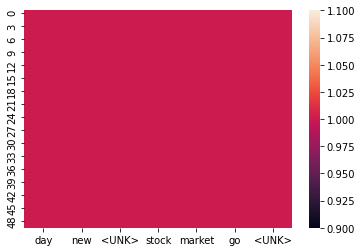

In [108]:
# Visualize a bi-gram filter's outputs
tokens = tokenizer.sequences_to_texts(sequences)[0].split(" ")
sns.heatmap(conv_outputs, xticklabels=tokens)


output should have been :





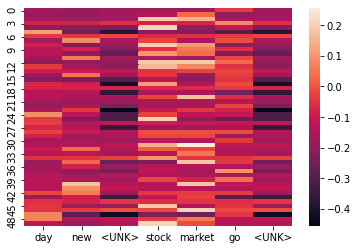



The filters have high values for the words stock and market which influenced the Business category classification.